In [1]:
import torch
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use gpu to run

In [3]:
class MatrixXRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Matrix-based implementation of the projection operator Π_k(X) = P·vec(X)
        
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Precompute all possible voxel coordinates
        z, y, x = torch.meshgrid(
            torch.arange(volume_shape[0], device=device),
            torch.arange(volume_shape[1], device=device),
            torch.arange(volume_shape[2], device=device),
            indexing='ij'
        )
        self.voxel_coords = torch.stack((x, y, z), dim=-1).float() - torch.tensor(volume_shape, device=device)//2
        
    def get_rotation_matrix(self, alpha, beta):
        """Same rotation matrix as before"""
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def build_projection_matrix(self, alpha, beta):
        """
        Build the sparse projection matrix P for given angles
        
        Returns:
            P: Sparse matrix of shape (h*w, m*n*p) where P[i*w+j, :] corresponds to pixel (i,j)
        """
        h, w = self.image_shape
        m, n, p = self.volume_shape
        total_pixels = h * w
        total_voxels = m * n * p
        
        # Initialize lists for sparse matrix construction
        row_indices = []
        col_indices = []
        
        # Apply rotation to all voxels
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(self.voxel_coords, R.T)
        
        # Perspective projection
        proj_coords = rotated_coords.clone()
        proj_coords[..., 2] += self.SOD
        
        # Only consider points in front of the detector
        valid_mask = proj_coords[..., 2] > 0
        valid_voxels = torch.nonzero(valid_mask)
        
        # Project valid voxels
        det_coords = (proj_coords[valid_mask][..., :2] / 
                     proj_coords[valid_mask][..., 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([w/2, h/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        pixel_valid = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < w) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < h))
        
        valid_pixel_coords = pixel_coords[pixel_valid]
        valid_voxel_indices = valid_voxels[pixel_valid]
        
        # Convert voxel indices to linear indices
        voxel_linear_indices = (
            valid_voxel_indices[:, 0] * n * p + 
            valid_voxel_indices[:, 1] * p + 
            valid_voxel_indices[:, 2])
        
        # Convert pixel coordinates to linear indices
        pixel_linear_indices = (
            valid_pixel_coords[:, 1] * w + 
            valid_pixel_coords[:, 0])
        
        # Create sparse matrix
        indices = torch.stack([pixel_linear_indices, voxel_linear_indices], dim=0)
        values = torch.ones(len(pixel_linear_indices), device=device)
        
        P = torch.sparse_coo_tensor(
            indices, 
            values, 
            size=(total_pixels, total_voxels),
            device=device
        )
        
        return P
    
    def project_volume(self, X, alpha, beta):
        """
        Project using sparse matrix multiplication: Π_k(X) = P·vec(X)
        
        Args:
            X: Binary 3D volume tensor (m,n,p)
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        # Build or get cached projection matrix
        P = self.build_projection_matrix(alpha, beta)
        
        # Vectorize input
        vec_X = X.flatten().float()
        
        # Sparse matrix multiplication
        proj_vec = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
        
        # Reshape and binarize
        proj_image = (proj_vec > 0).reshape(self.image_shape)
        
        return proj_image

In [4]:
def create_test_objects(volume_shape):
    """Create all 7 test 3D objects with consistent orientation"""
    volume = torch.zeros(volume_shape, device=device)
    center = torch.tensor(volume_shape) // 2
    
    # Create coordinate grids (Z,Y,X order for volume dimensions)
    z, y, x = torch.meshgrid(
        torch.arange(volume_shape[0], device=device),  # Z (depth)
        torch.arange(volume_shape[1], device=device),  # Y (vertical)
        torch.arange(volume_shape[2], device=device),  # X (horizontal)
        indexing='ij'
    )

    # 1. Cube (aligned with axes)
    cube_size = 20
    half = cube_size // 2
    cube = volume.clone()
    cube[center[0]-half:center[0]+half,
         center[1]-half:center[1]+half,
         center[2]-half:center[2]+half] = 1

    # 2. Cylinder (horizontal along X-axis)
    cylinder = volume.clone()
    radius = 10
    length = 30  # Length along X-axis
    mask = ((y - center[1])**2 + (z - center[0])**2 <= radius**2) & \
           (x >= center[2]-length//2) & (x <= center[2]+length//2)
    cylinder[mask] = 1

    # 3. Star (3D cross aligned with axes)
    star = volume.clone()
    cross_width = 5
    cross_length = 25
    # X-axis cross (horizontal)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_length//2:center[2]+cross_length//2] = 1
    # Y-axis cross (vertical)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_length//2:center[1]+cross_length//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1
    # Z-axis cross (depth)
    star[center[0]-cross_length//2:center[0]+cross_length//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1

    # 4. Sphere (perfectly symmetrical)
    sphere = volume.clone()
    sphere_radius = 15
    mask = ((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2) <= sphere_radius**2
    sphere[mask] = 1

    # 5. Torus (donut, horizontal orientation)
    torus = volume.clone()
    R = 15  # Major radius
    r = 5   # Minor radius
    mask = (torch.sqrt((y - center[1])**2 + (z - center[0])**2) - R)**2 + (x - center[2])**2 <= r**2
    torus[mask] = 1

    # 6. Pyramid (base on XY plane, peak along +Z)
    pyramid = volume.clone()
    base_size = 25
    height = 25
    for level in range(height):
        current_size = base_size * (1 - level/height)
        if current_size < 1:
            break
        half = int(current_size // 2)
        pyramid[center[0] + level,
                center[1]-half:center[1]+half,
                center[2]-half:center[2]+half] = 1

    # 7. Helix (horizontal along X-axis)
    helix = volume.clone()
    helix_radius = 10
    turns = 2
    pitch = 30  # Height per full turn
    for t in torch.linspace(0, turns*2*np.pi, 100):
        x_pos = int(center[2] + helix_radius * math.cos(t))  # X-coordinate
        y_pos = int(center[1] + helix_radius * math.sin(t))  # Y-coordinate
        z_pos = int(center[0] + pitch * t / (2*np.pi))      # Z-coordinate
        if all(0 <= p < s for p, s in zip((z_pos, y_pos, x_pos), volume_shape)):
            helix[z_pos, y_pos, x_pos] = 1
        # Add thickness
        for dz, dy, dx in [(0,0,0), (0,0,1), (0,1,0), (1,0,0)]:
            nz, ny, nx = z_pos+dz, y_pos+dy, x_pos+dx
            if all(0 <= p < s for p, s in zip((nz, ny, nx), volume_shape)):
                helix[nz, ny, nx] = 1

    return {
        'Cube': cube,
        'Cylinder': cylinder,
        'Star': star,
        'Sphere': sphere,
        'Torus': torus,
        'Pyramid': pyramid,
        'Helix': helix
    }


Visualizing Cube...


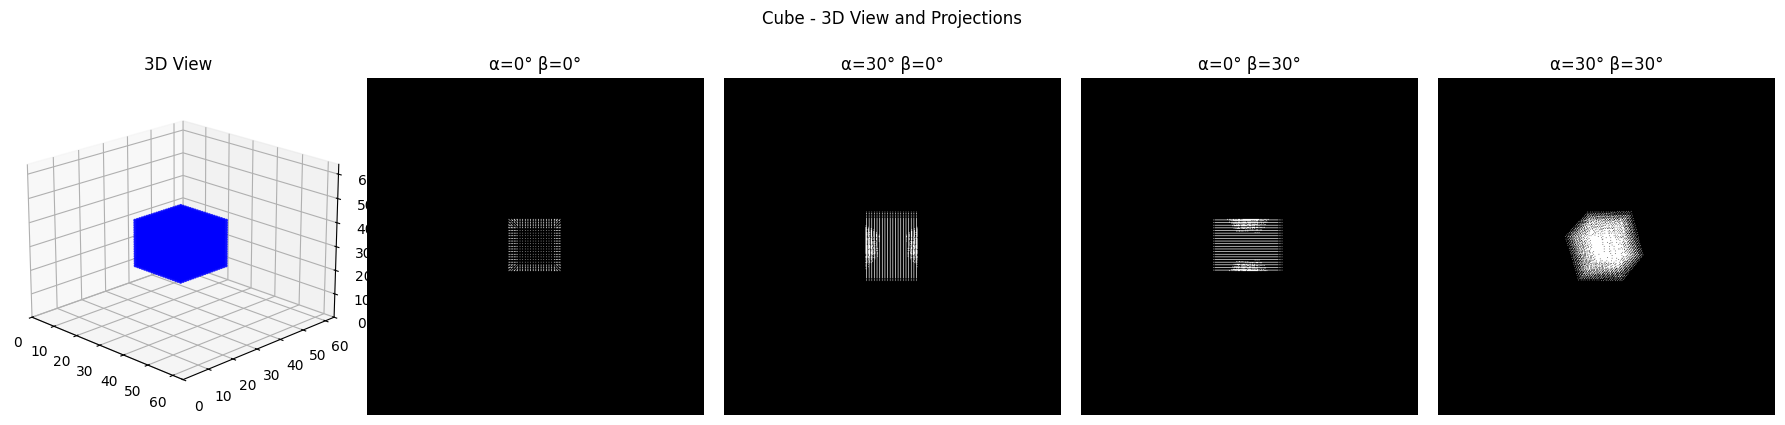


Visualizing Cylinder...


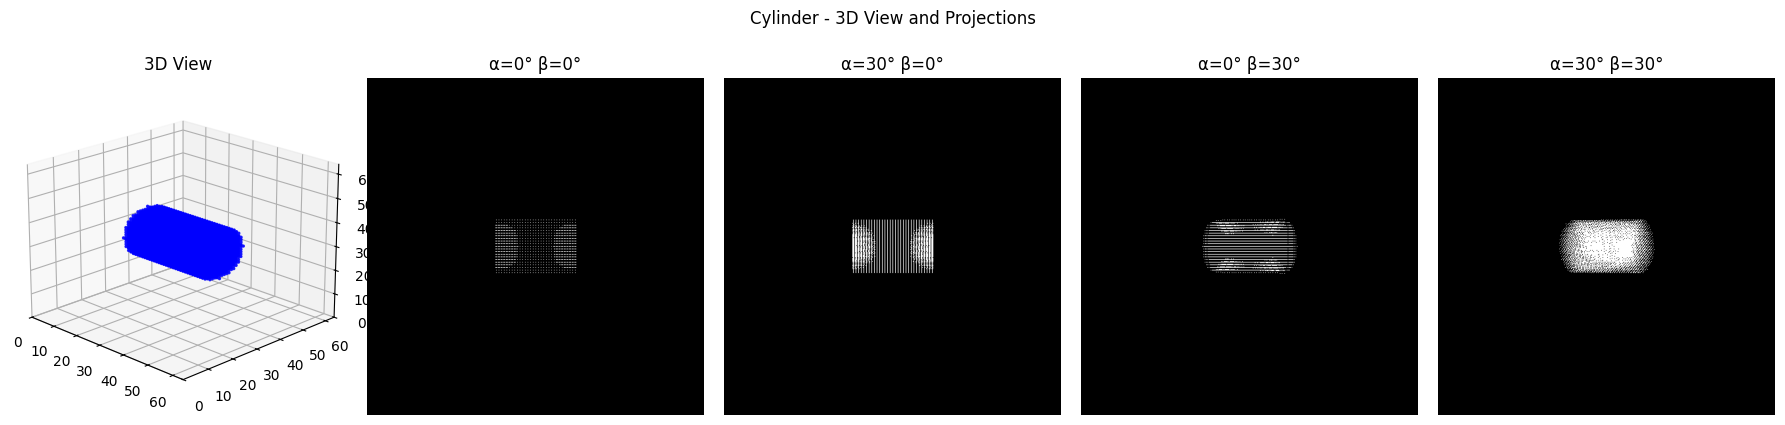


Visualizing Star...


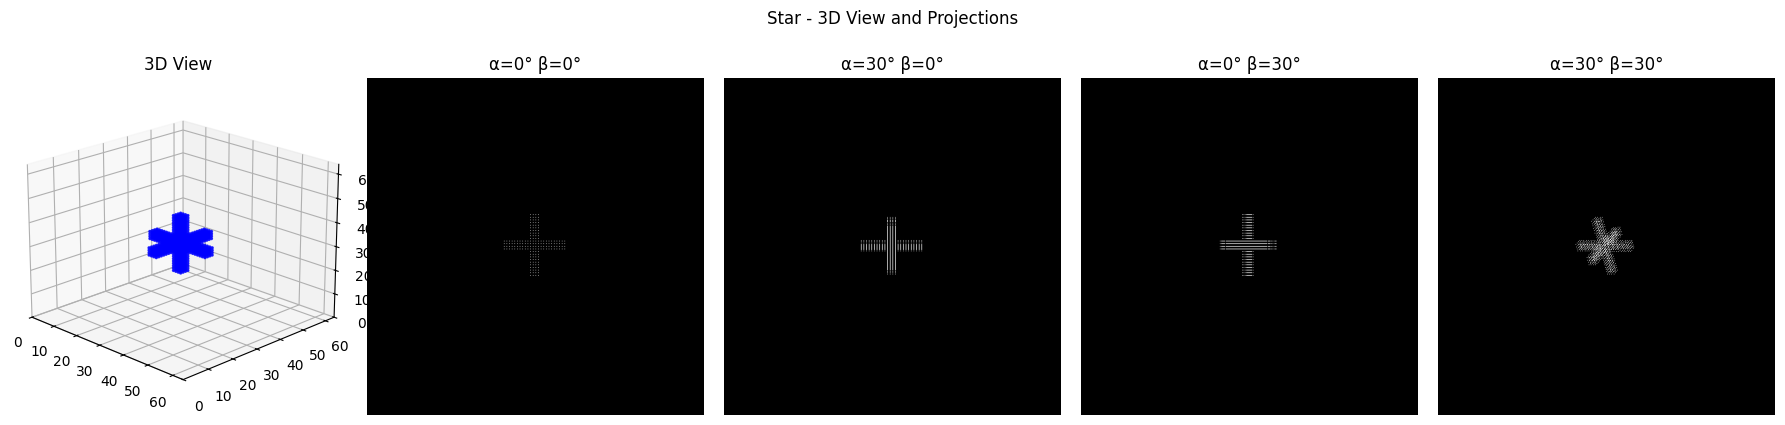


Visualizing Sphere...


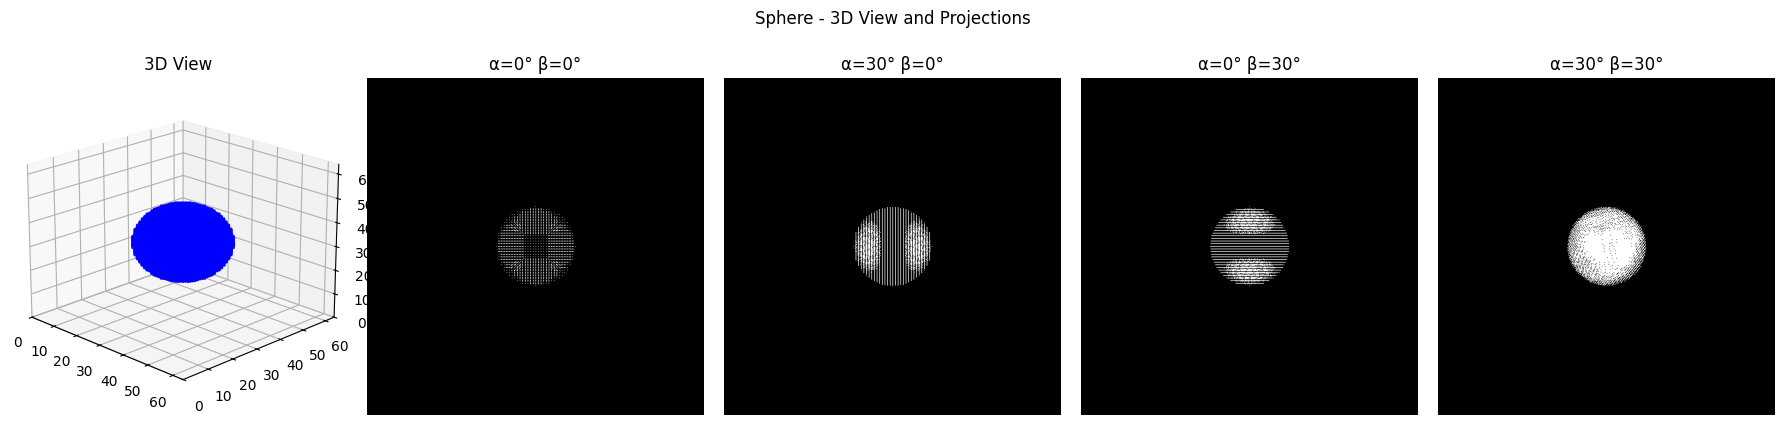


Visualizing Torus...


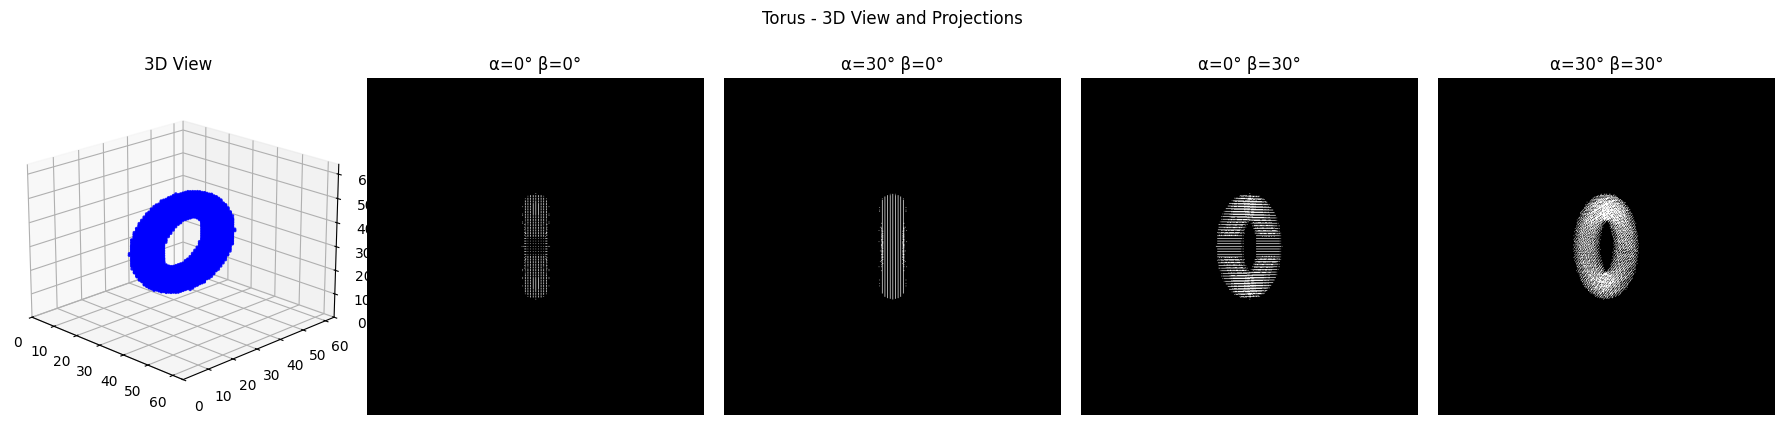


Visualizing Pyramid...


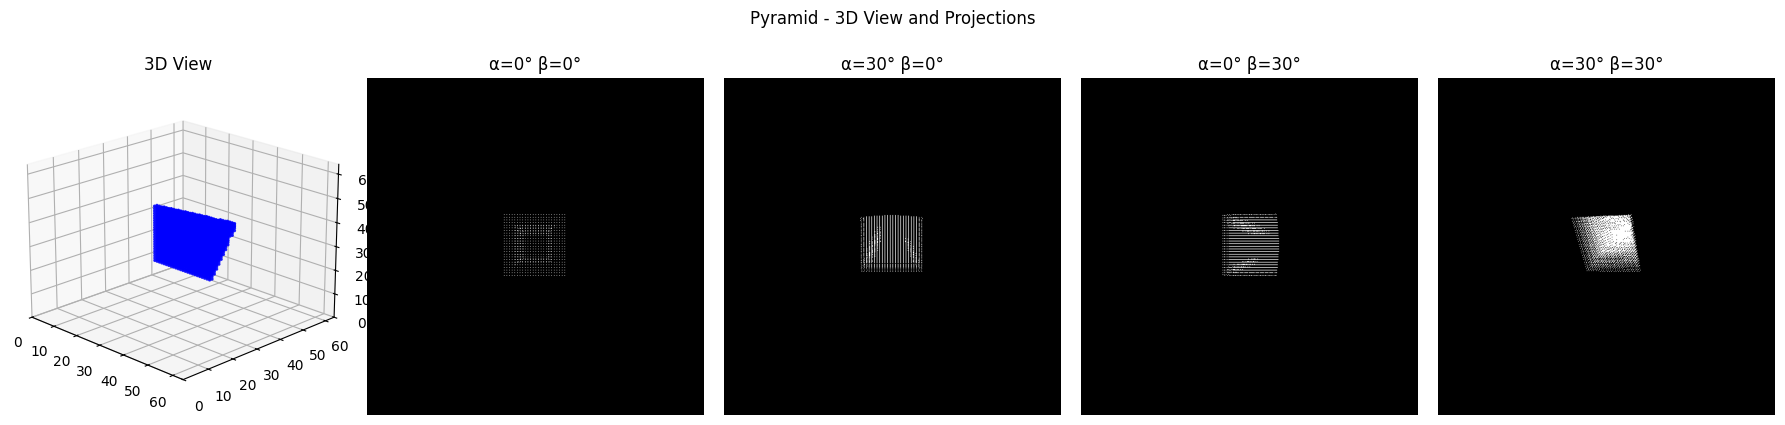


Visualizing Helix...


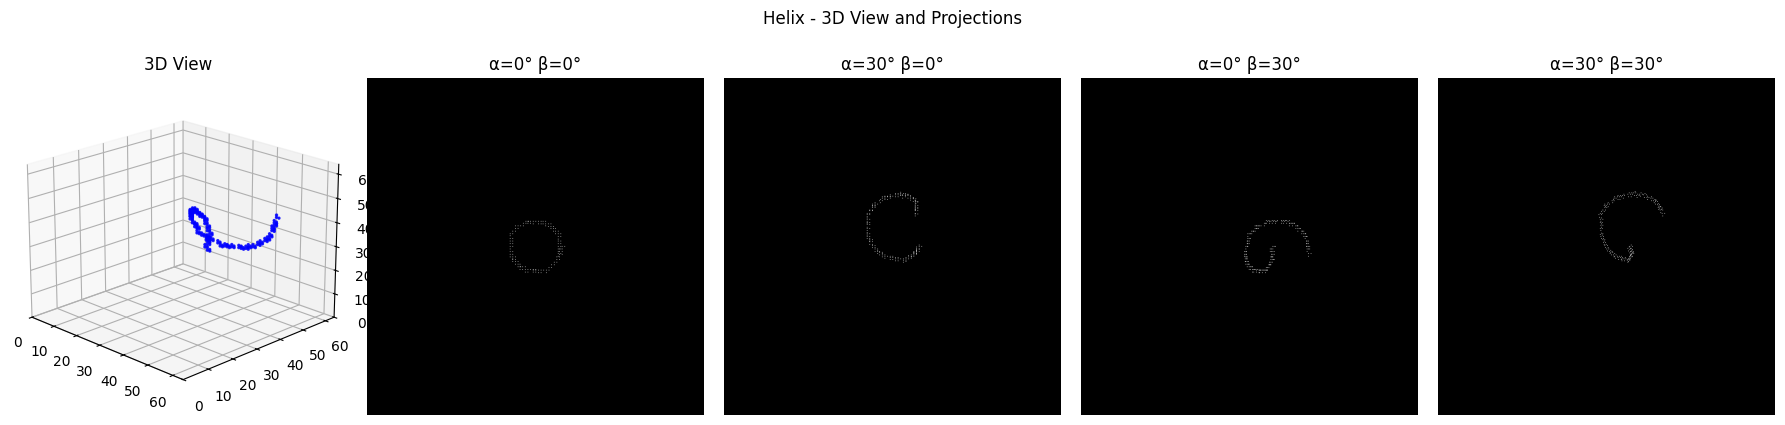

In [5]:
def plot_3d_voxels(voxels, title):
    """Visualize 3D voxels with consistent coordinate system"""
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = torch.nonzero(voxels).cpu().numpy()
    if len(coords) > 0:
        # Plot as (X, Z, Y) to match projection views
        ax.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                  color='blue', s=2, alpha=0.8, depthshade=True)
    
    ax.set_xlabel('X (Horizontal)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Vertical)')
    ax.set_title(title, pad=10)
    ax.set_xlim(0, voxels.shape[2])
    ax.set_ylim(0, voxels.shape[0])
    ax.set_zlim(0, voxels.shape[1])
    ax.view_init(elev=20, azim=-45)  # Standard isometric view
    plt.tight_layout()
    plt.show()

def visualize_all_objects(test_objects, projector):
    """Visualize 3D objects and their X-ray projections"""
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, obj_volume in test_objects.items():
        print(f"\nVisualizing {obj_name}...")
        
        # Combined visualization
        fig = plt.figure(figsize=(18, 4))
        fig.suptitle(f'{obj_name} - 3D View and Projections', y=1.05)
        
        # 3D View (subplot 1)
        ax_3d = fig.add_subplot(1, 5, 1, projection='3d')
        coords = torch.nonzero(obj_volume).cpu().numpy()
        if len(coords) > 0:
            ax_3d.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                         color='blue', s=2, alpha=0.8)
        ax_3d.set_title('3D View')
        ax_3d.set_xlim(0, obj_volume.shape[2])
        ax_3d.set_ylim(0, obj_volume.shape[0])
        ax_3d.set_zlim(0, obj_volume.shape[1])
        ax_3d.view_init(elev=20, azim=-45)
        
        # Projections (subplots 2-5)
        for i, (alpha, beta) in enumerate(angles):
            ax = fig.add_subplot(1, 5, i+2)
            proj_image = projector.project_volume(obj_volume, alpha, beta)
            ax.imshow(proj_image.cpu().numpy(), cmap='gray')
            ax.set_title(f'α={math.degrees(alpha):.0f}° β={math.degrees(beta):.0f}°')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize and run visualization
volume_shape = (64, 64, 64)
projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
test_objects = create_test_objects(volume_shape)
visualize_all_objects(test_objects, projector)


Visualizing Cube...


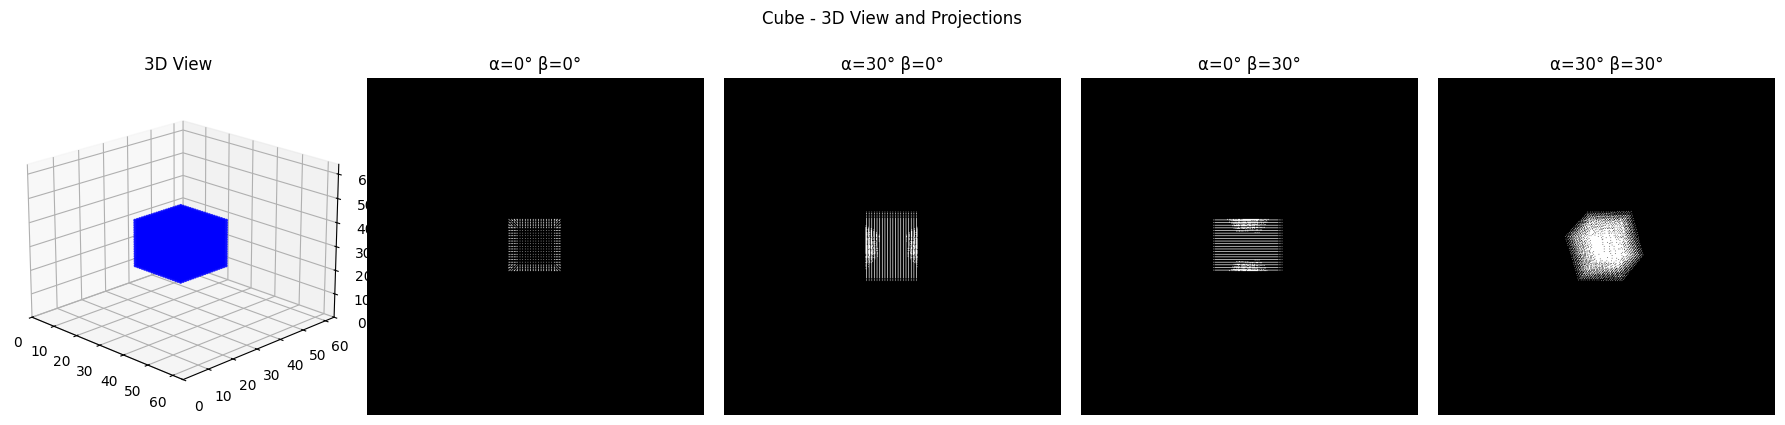


Visualizing Cylinder...


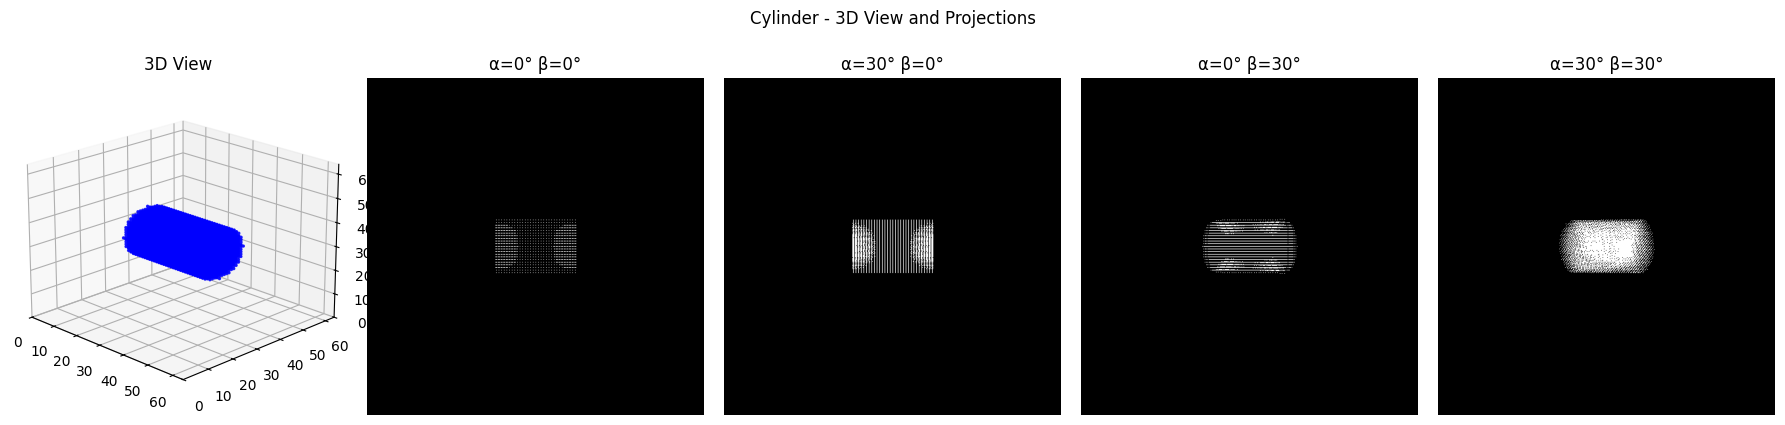


Visualizing Star...


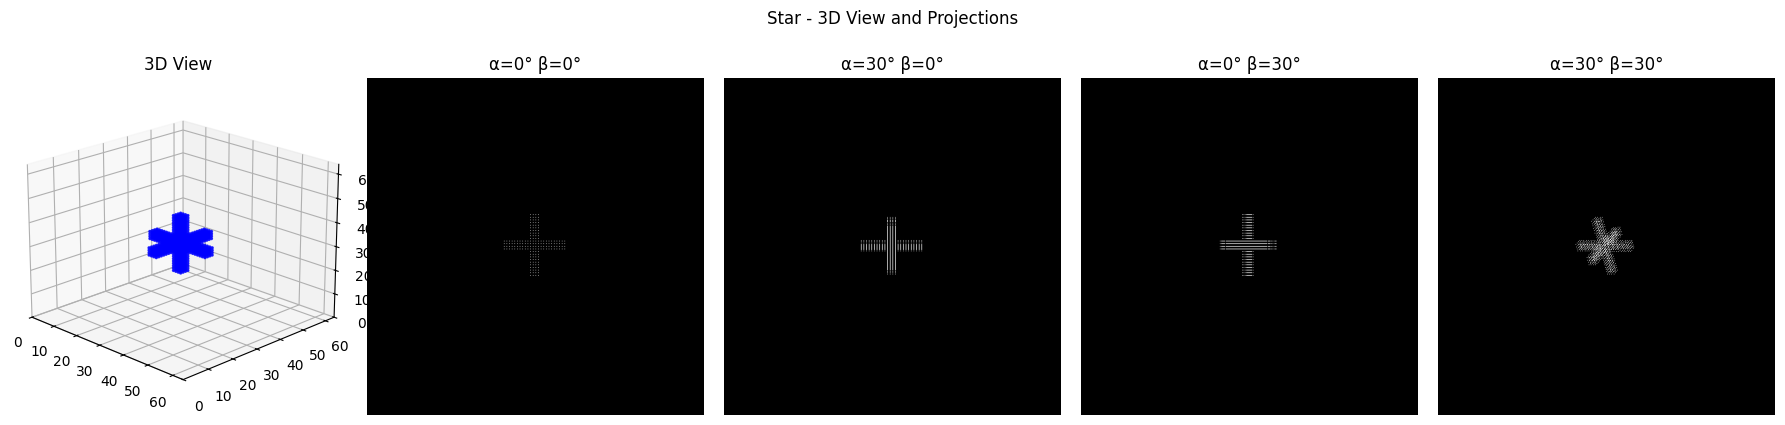


Visualizing Sphere...


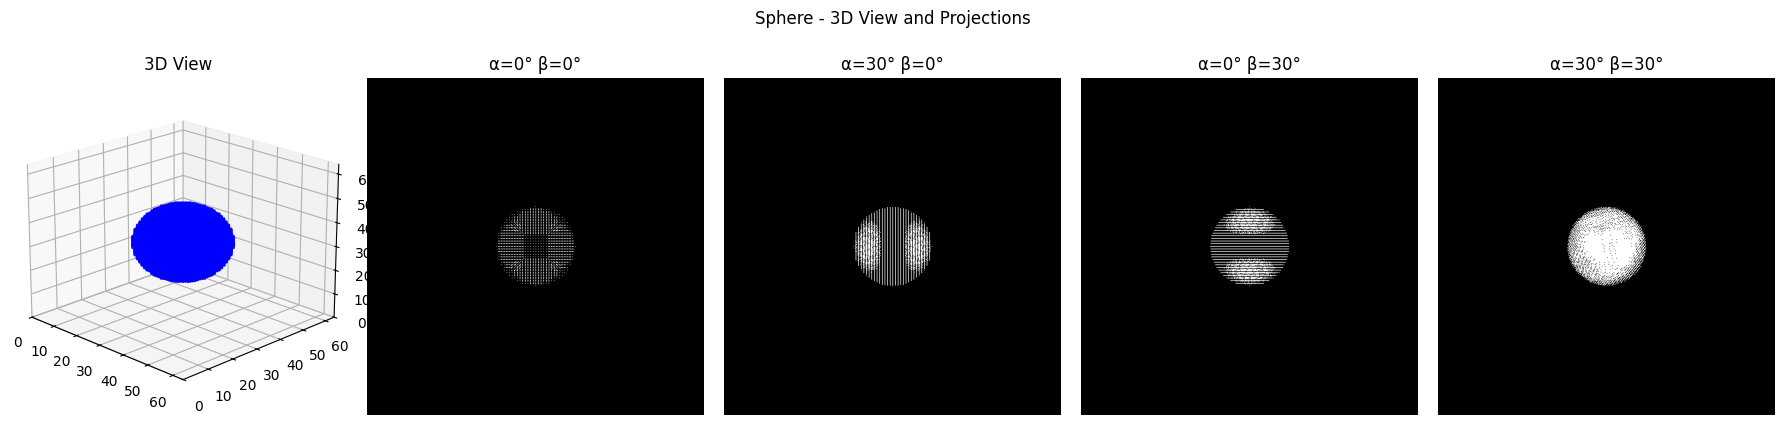


Visualizing Torus...


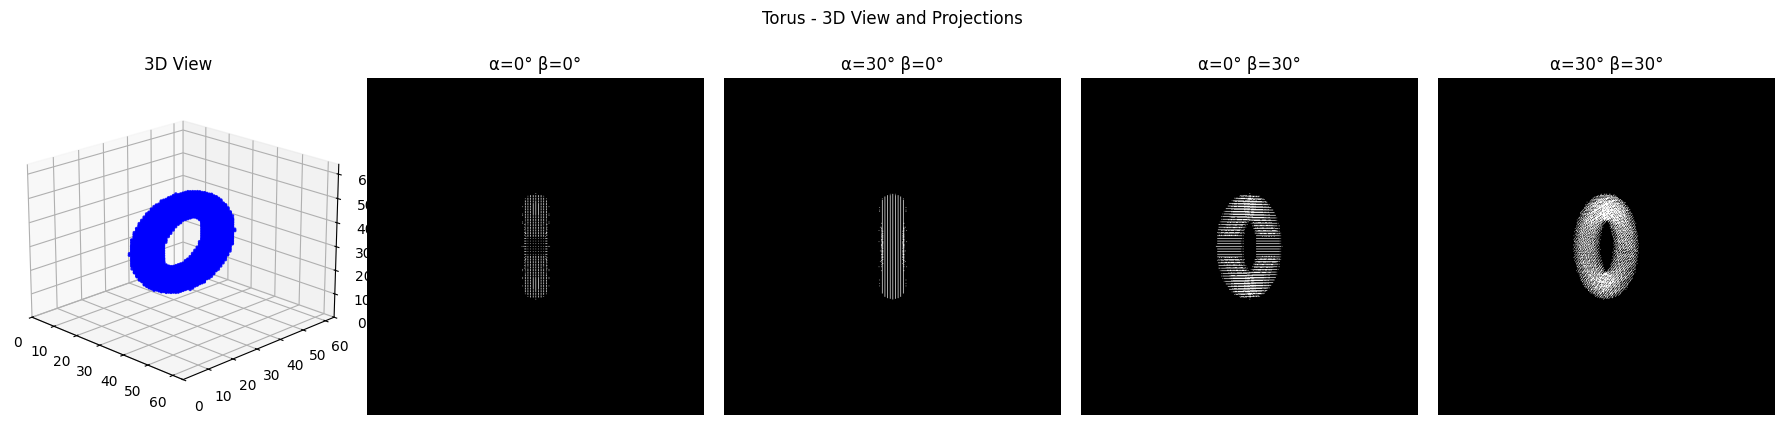


Visualizing Pyramid...


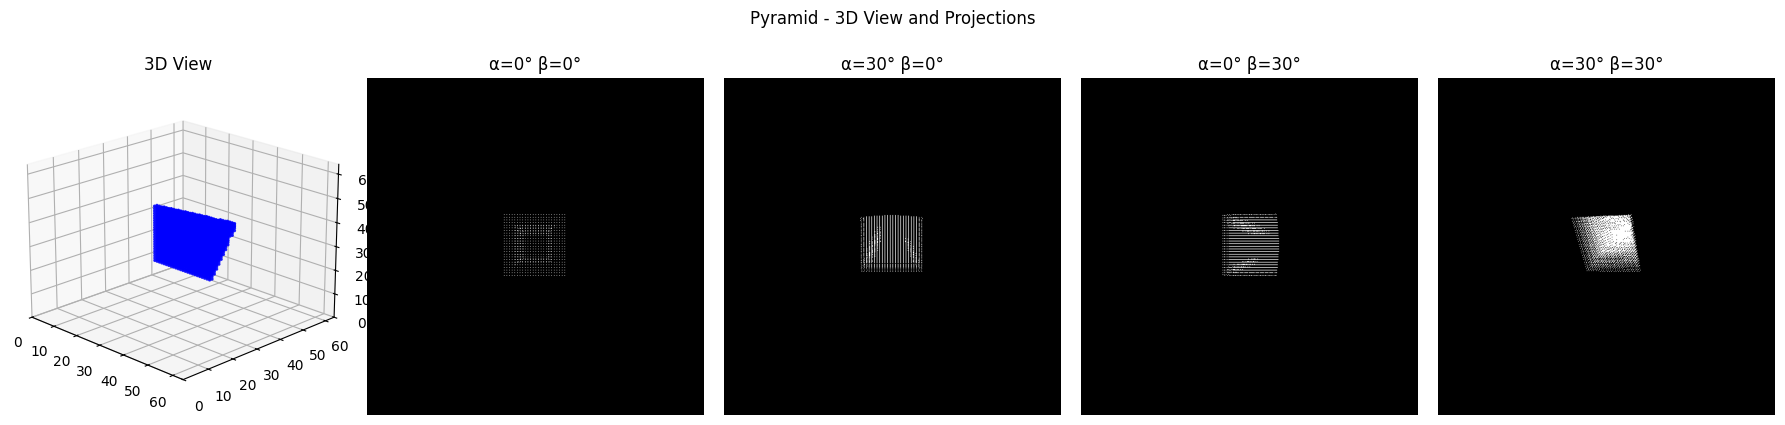


Visualizing Helix...


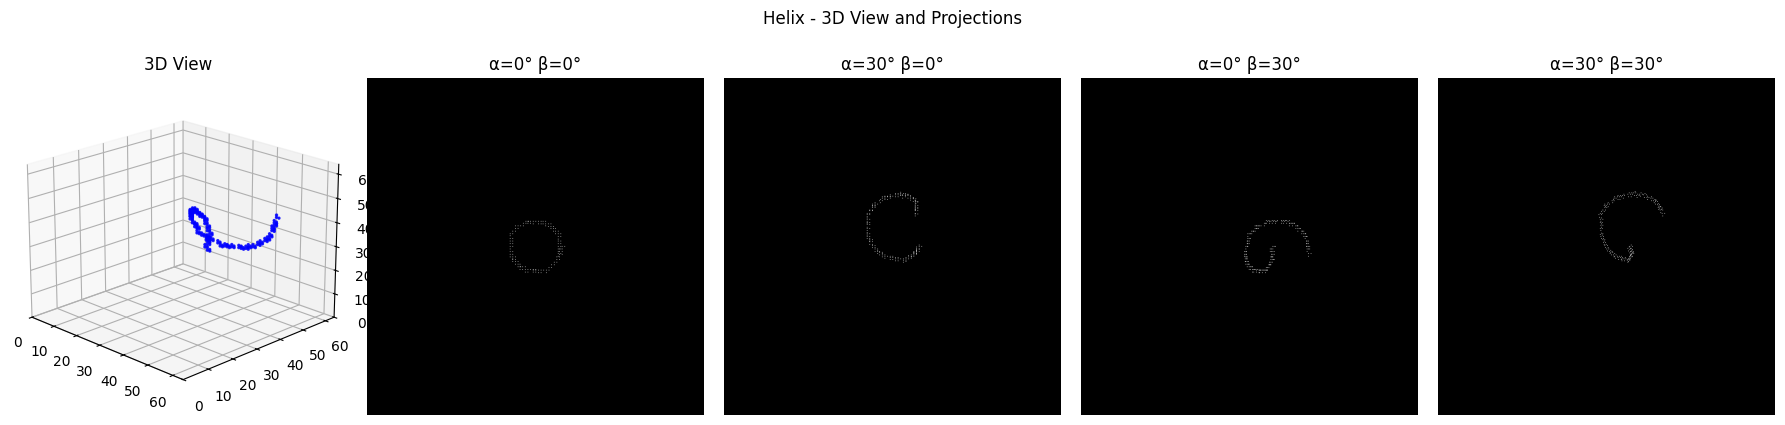


Reconstructing Cube...


  0%|          | 3/5000 [00:00<07:11, 11.58it/s]

Iter <built-in function iter>: Loss=1558811.50, Grad Norm=13102.4619


  2%|▏         | 106/5000 [00:02<01:33, 52.36it/s]

Iter <built-in function iter>: Loss=1055126.88, Grad Norm=10659.2480


  4%|▍         | 208/5000 [00:04<01:30, 52.82it/s]

Iter <built-in function iter>: Loss=715197.00, Grad Norm=8670.4893


  6%|▌         | 310/5000 [00:06<01:31, 51.31it/s]

Iter <built-in function iter>: Loss=485973.44, Grad Norm=7054.0645


  8%|▊         | 388/5000 [00:07<01:30, 50.81it/s]

In [ ]:
def reconstruct_from_projections(test_objects, projector, num_iterations=5000, lr=0.001):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            projection_matrices.append(P)
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                proj = proj.reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            #reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            #total_loss += 0.1 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)
        
        # 5. Store results (use the best solution found during optimization)
        threshold = 0.5  # For converting back to binary
        binary_recon = (best_X > threshold).float()
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': binary_recon,
            'relaxed': best_X,
            'loss_history': loss_history
        }
    
    return results

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # First visualize the objects and their projections
    visualize_all_objects(test_objects, projector)
    
    # Then perform reconstruction
    reconstruction_results = reconstruct_from_projections(test_objects, projector)
    
    # Visualize reconstruction results
    visualize_reconstruction_results(reconstruction_results)